<a href="https://colab.research.google.com/github/toyinolape/DataCamp_DataScience/blob/master/Kaggle_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this competition you are predicting the values of air pollution measurements over time, based on basic weather information (temperature and humidity) and the input values of 5 sensors.

The three target values to you to predict are: target_carbon_monoxide, target_benzene, and target_nitrogen_oxides

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import time
import random

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "sample_submission.csv" with length 78716 bytes
User uploaded file "test.csv" with length 154260 bytes
User uploaded file "train.csv" with length 593980 bytes


In [5]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")
df_train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [6]:
df_train["date_time"] = pd.to_datetime(df_train['date_time'], format= "%Y-%m-%d %H:%M:%S")
df_test["date_time"] = pd.to_datetime(df_test['date_time'], format= "%Y-%m-%d %H:%M:%S")


In [7]:
df_test.shape

(2247, 9)

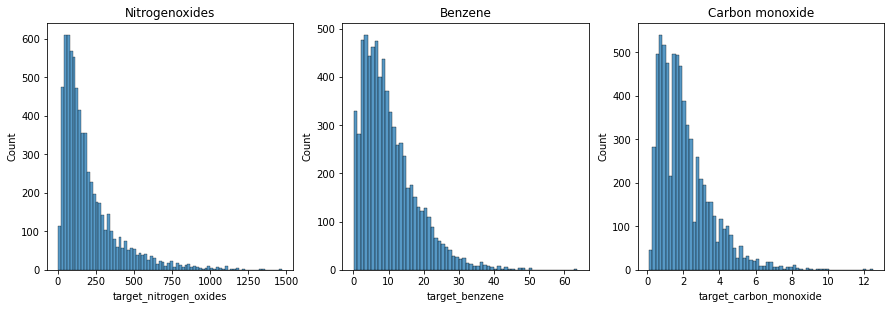

In [8]:
import seaborn as sns 
fig = plt.figure(figsize=(15,10))

#  subplot #1
plt.subplot(2,3,1)
plt.title('Nitrogenoxides')
sns.histplot(data = df_train, x='target_nitrogen_oxides')

#  subplot #2
plt.subplot(2,3,2)
plt.title('Benzene')
sns.histplot(data = df_train,x='target_benzene')

#  subplot #3
plt.subplot(233)
plt.title('Carbon monoxide')
sns.histplot(data = df_train, x="target_carbon_monoxide")


plt.show() 


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
def make_new_features(df):
    df["month"] = df["date_time"].dt.month
    df["day_of_week"] = df["date_time"].dt.dayofweek
    df["day_of_year"] = df["date_time"].dt.dayofyear
    df["hour"] = df["date_time"].dt.hour
    df["quarter"] = df["date_time"].dt.quarter
    df["week_of_year"] = df["date_time"].dt.isocalendar().week.astype("int")
    df["working_hours"] =  df["hour"].isin(np.arange(8, 21, 1)).astype("int")
    df["is_weekend"] = (df["date_time"].dt.dayofweek >= 5).astype("int")
    return df

df_new_train = make_new_features(df_train)
df_new_test = make_new_features(df_test)

In [11]:
df_new_train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,month,day_of_week,day_of_year,hour,quarter,week_of_year,working_hours,is_weekend
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,3,2,69,18,1,10,1,0
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,3,2,69,19,1,10,1,0
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,3,2,69,20,1,10,1,0
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,3,2,69,21,1,10,0,0
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,3,2,69,22,1,10,0,0


In [12]:
df_new_test['date_time'] = df_new_test['date_time'].astype('datetime64[ns]').astype(np.int64)/10**9
df_new_train['date_time'] = df_new_train['date_time'].astype('datetime64[ns]').astype(np.int64)/10**9

In [13]:
df_new_test.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,day_of_week,day_of_year,hour,quarter,week_of_year,working_hours,is_weekend
0,1.293840e+09,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1,5,1,0,1,52,0,1
1,1.293844e+09,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,1,5,1,1,1,52,0,1
2,1.293847e+09,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,1,5,1,2,1,52,0,1
3,1.293851e+09,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,1,5,1,3,1,52,0,1
4,1.293854e+09,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,1,5,1,4,1,52,0,1


In [14]:
cols = df_new_train.columns
# Explore using the training dataset and spliting to drop each target and train to see if the accuracy is better
X_c = df_new_train.drop(["target_carbon_monoxide"],axis=1).values
X_b = df_new_train.drop(["target_benzene"],axis=1).values
X_n = df_new_train.drop(["target_nitrogen_oxides"],axis=1).values

In [15]:
X_train = df_new_train.drop(["target_benzene", "target_carbon_monoxide","target_nitrogen_oxides"], axis=1).values

In [16]:
X_test = df_new_test.values
t_c = df_new_train['target_carbon_monoxide'].values.reshape(-1,1)
t_b = df_new_train['target_benzene'].values.reshape(-1,1)
t_n = df_new_train['target_nitrogen_oxides'].values.reshape(-1,1)

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
rf.fit(X_train,t_c)
sub['target_carbon_monoxide'] = rf.predict(X_test)

rf = RandomForestRegressor()
rf.fit(X_train,t_b)
sub['target_benzene'] = rf.predict(X_test)

rf = RandomForestRegressor()
rf.fit(X_train,t_n)
sub['target_nitrogen_oxides'] = rf.predict(X_test)

In [47]:
sub.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.668,4.455,193.387
1,2011-01-01 01:00:00,2.092,7.411,312.786
2,2011-01-01 02:00:00,1.946,7.552,323.039
3,2011-01-01 03:00:00,2.080,8.481,347.985
4,2011-01-01 04:00:00,1.751,6.817,225.395


In [52]:
sub.to_csv("submission.csv", index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TAKE 2

This is a second take with the hyperparameters tuned with grid search. We would determine if the score is improved 

In [ ]:
"""
Optimize the hyperparamters with grid search and train 

Also fit and predict for the various targets. Remember to test for accuracy

"""

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = GradientBoostingRegressor(**params)

reg.fit(X_train,t_c)
sub['target_carbon_monoxide'] = reg.predict(X_test)

reg.fit(X_train,t_b)
sub['target_benzene'] = reg.predict(X_test)

reg.fit(X_train,t_n)
sub['target_nitrogen_oxides'] = reg.predict(X_test)

In [19]:
sub.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.675901,5.284551,277.117936
1,2011-01-01 01:00:00,2.035294,7.370183,290.616546
2,2011-01-01 02:00:00,1.717537,7.497969,287.595245
3,2011-01-01 03:00:00,1.850250,8.436867,301.966129
4,2011-01-01 04:00:00,1.216155,6.675268,216.378073


In [21]:


mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

NameError: ignored